# Generative Adversarial Networks in PyTorch

In [2]:
# Uncomment and install libraries if imports fail
# !conda install numpy pandas pytorch torchvision cpuonly -c pytorch -y
# !pip install matplotlib --upgrade --quiet

## Loading the Data

In [3]:
DATA_DIR = '../input/animefacedataset/'

In [4]:
import os

print(os.listdir(DATA_DIR))

['images']


In [5]:
print(os.listdir(DATA_DIR+'/images')[:10])

['31602_2010.jpg', '61389_2018.jpg', '28789_2010.jpg', '5501_2003.jpg', '51466_2015.jpg', '32029_2010.jpg', '29455_2010.jpg', '35769_2011.jpg', '28912_2010.jpg', '797_2000.jpg']


In [6]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T

In [7]:
image_size = 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [8]:
train_ds = ImageFolder(DATA_DIR, transform=T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor(),
    T.Normalize(*stats)]))

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)

In [9]:
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [10]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [11]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

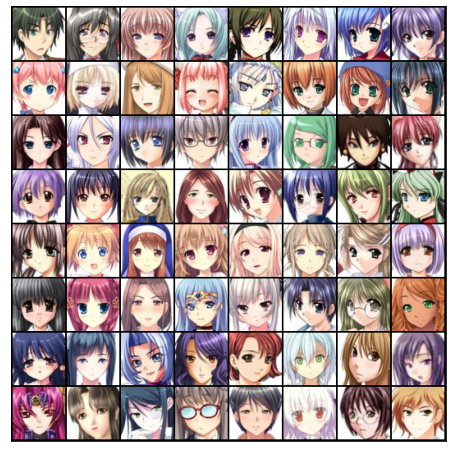

In [12]:
show_batch(train_dl)

In [13]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [14]:
device = get_default_device()
device

device(type='cuda')

In [15]:
train_dl = DeviceDataLoader(train_dl, device)

In [16]:
import torch.nn as nn

In [17]:
discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

In [18]:
discriminator = to_device(discriminator, device)

In [19]:
latent_size = 128

In [20]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

torch.Size([128, 3, 64, 64])


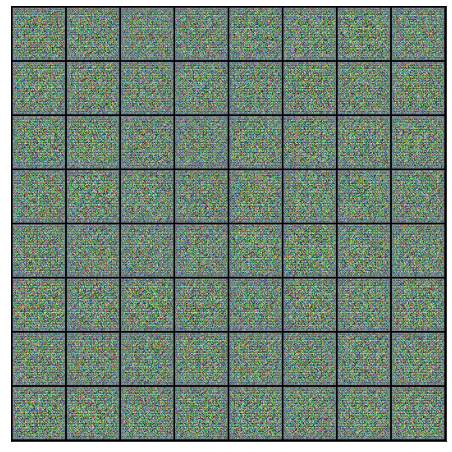

In [21]:
xb = torch.randn(batch_size, latent_size, 1, 1) # random latent tensors
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [22]:
generator = to_device(generator, device)

In [23]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

In [24]:
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)
    
    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)
    
    # Update generator weights
    loss.backward()
    opt_g.step()
    
    return loss.item()

In [25]:
from torchvision.utils import save_image

In [26]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [27]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [28]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

Saving generated-images-0000.png


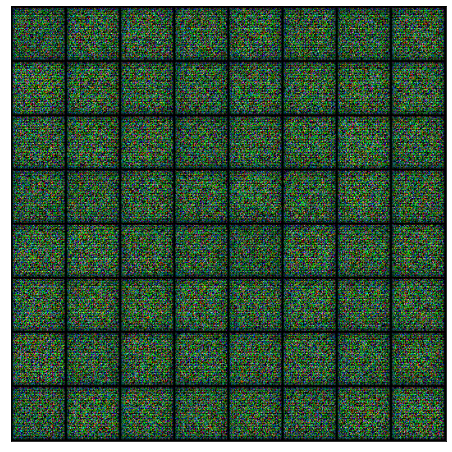

In [29]:
save_samples(0, fixed_latent)

In [30]:
from tqdm.notebook import tqdm
import torch.nn.functional as F

In [31]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    
    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)
            
        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
    
        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)
    
    return losses_g, losses_d, real_scores, fake_scores

In [32]:
lr = 0.0002
epochs = 25

In [33]:
history = fit(epochs, lr)


Epoch [1/25], loss_g: 4.7211, loss_d: 0.4680, real_score: 0.8618, fake_score: 0.2438
Saving generated-images-0001.png



Epoch [2/25], loss_g: 5.1108, loss_d: 0.6015, real_score: 0.8566, fake_score: 0.3299
Saving generated-images-0002.png



Epoch [3/25], loss_g: 3.4286, loss_d: 0.0447, real_score: 0.9723, fake_score: 0.0151
Saving generated-images-0003.png



Epoch [4/25], loss_g: 8.0204, loss_d: 1.1123, real_score: 0.4496, fake_score: 0.0002
Saving generated-images-0004.png



Epoch [5/25], loss_g: 7.0453, loss_d: 0.3459, real_score: 0.7455, fake_score: 0.0028
Saving generated-images-0005.png



Epoch [6/25], loss_g: 9.2653, loss_d: 0.5669, real_score: 0.9459, fake_score: 0.3407
Saving generated-images-0006.png



Epoch [7/25], loss_g: 3.5084, loss_d: 0.5883, real_score: 0.6393, fake_score: 0.0080
Saving generated-images-0007.png



Epoch [8/25], loss_g: 10.8898, loss_d: 1.0139, real_score: 0.9985, fake_score: 0.5361
Saving generated-images-0008.png



Epoch [9/25], loss_g: 8.5175, loss_d: 0.5184, real_score: 0.9427, fake_score: 0.2915
Saving generated-images-0009.png



Epoch [10/25], loss_g: 3.8214, loss_d: 0.3005, real_score: 0.8624, fake_score: 0.0894
Saving generated-images-0010.png



Epoch [11/25], loss_g: 6.0320, loss_d: 0.3682, real_score: 0.9628, fake_score: 0.2463
Saving generated-images-0011.png



Epoch [12/25], loss_g: 5.6195, loss_d: 0.1726, real_score: 0.9732, fake_score: 0.1241
Saving generated-images-0012.png



Epoch [13/25], loss_g: 3.0733, loss_d: 0.1265, real_score: 0.9245, fake_score: 0.0392
Saving generated-images-0013.png



Epoch [14/25], loss_g: 4.3183, loss_d: 0.3074, real_score: 0.7740, fake_score: 0.0122
Saving generated-images-0014.png



Epoch [15/25], loss_g: 4.3277, loss_d: 2.9632, real_score: 0.1026, fake_score: 0.0001
Saving generated-images-0015.png



Epoch [16/25], loss_g: 3.2608, loss_d: 0.1237, real_score: 0.9311, fake_score: 0.0426
Saving generated-images-0016.png



Epoch [17/25], loss_g: 4.5423, loss_d: 0.4218, real_score: 0.7529, fake_score: 0.0148
Saving generated-images-0017.png



Epoch [18/25], loss_g: 3.1515, loss_d: 0.1450, real_score: 0.9091, fake_score: 0.0395
Saving generated-images-0018.png



Epoch [19/25], loss_g: 5.4008, loss_d: 0.1759, real_score: 0.9794, fake_score: 0.1311
Saving generated-images-0019.png



Epoch [20/25], loss_g: 4.3114, loss_d: 0.1303, real_score: 0.9484, fake_score: 0.0675
Saving generated-images-0020.png



Epoch [21/25], loss_g: 4.5028, loss_d: 0.1445, real_score: 0.9483, fake_score: 0.0810
Saving generated-images-0021.png



Epoch [22/25], loss_g: 3.8705, loss_d: 0.1363, real_score: 0.9000, fake_score: 0.0183
Saving generated-images-0022.png



Epoch [23/25], loss_g: 4.3787, loss_d: 0.0868, real_score: 0.9775, fake_score: 0.0569
Saving generated-images-0023.png



Epoch [24/25], loss_g: 4.7504, loss_d: 0.0858, real_score: 0.9414, fake_score: 0.0221
Saving generated-images-0024.png



Epoch [25/25], loss_g: 4.6749, loss_d: 0.1880, real_score: 0.9917, fake_score: 0.1437
Saving generated-images-0025.png


In [34]:
losses_g, losses_d, real_scores, fake_scores = history

In [35]:
# Save the model checkpoints 
torch.save(generator.state_dict(), 'G.ckpt')
torch.save(discriminator.state_dict(), 'D.ckpt')

Here's how the generated images look, after the 1st, 5th and 10th epochs of training.

In [36]:
from IPython.display import Image

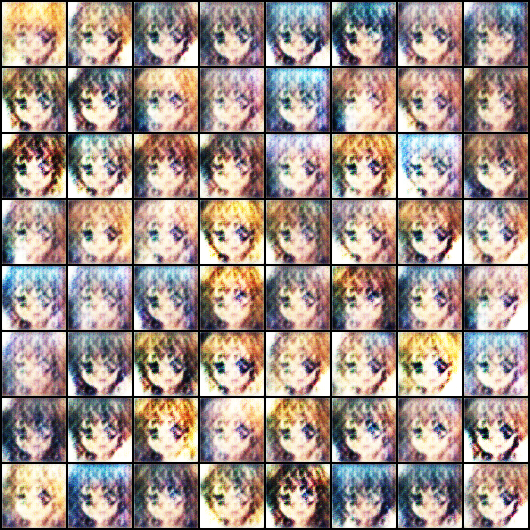

In [37]:
Image('./generated/generated-images-0001.png')

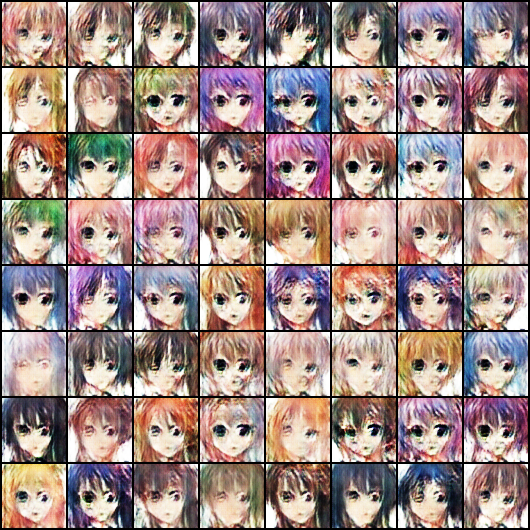

In [38]:
Image('./generated/generated-images-0005.png')

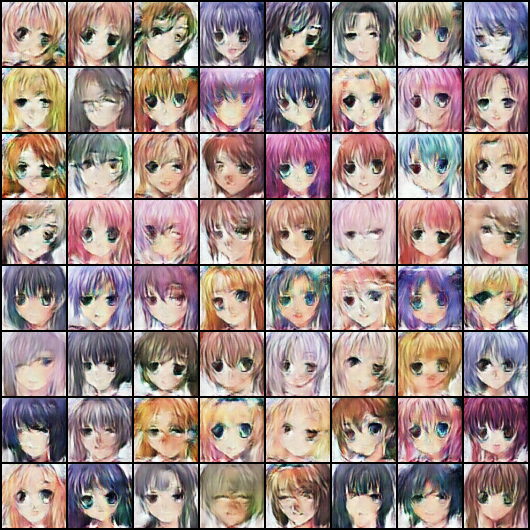

In [39]:
Image('./generated/generated-images-0010.png')

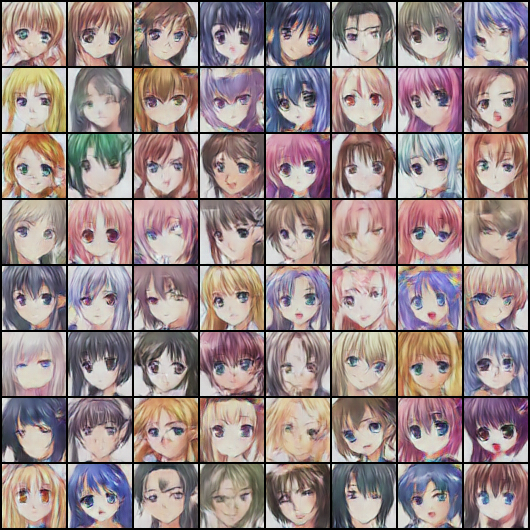

In [40]:
Image('./generated/generated-images-0020.png')

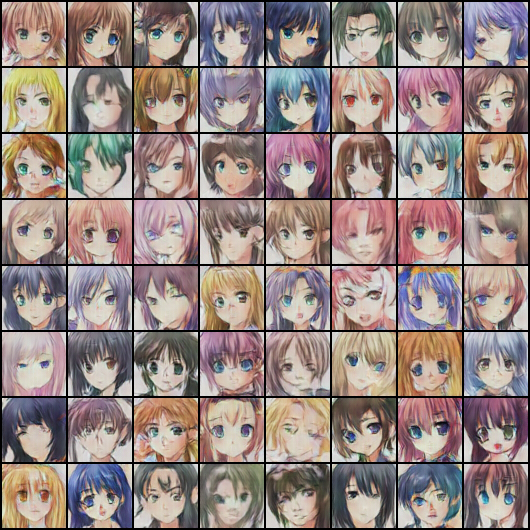

In [41]:
Image('./generated/generated-images-0025.png')

We can visualize the training process by combining the sample images generated after each epoch into a video using OpenCV.

In [42]:
import cv2
import os

vid_fname = 'gans_training.avi'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'generated' in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 1, (530,530))
[out.write(cv2.imread(fname)) for fname in files]
out.release()

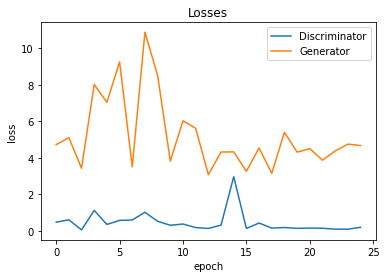

In [43]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

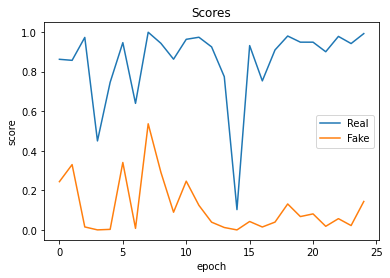

In [44]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');